# VIGIA Competition Notebook

This notebook is a conversion of the `vigia-competition.py` script. Each section of the original script is split into one or more cells.

In [ ]:
import pandas as pd, numpy as np, tensorflow as tf
from sklearn.model_selection import StratifiedKFold  # CV splitter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

/Users/mymac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [13]:
IMG_SIZE     = (32, 32)        # input resolution in your CNN
BATCH_SIZE   = 64
EPOCHS       = 15
N_SPLITS     = 5               # k-fold
SEED         = 42

TRAIN_DIR    = "archive/train/train/"   # path with labelled jpg
TEST_DIR     = "archive/train/train/"     # modified: use training directory since no true test labels
TRAIN_CSV    = "archive/train.csv"


In [14]:
train_df = pd.read_csv(TRAIN_CSV)
print("Training samples:", len(train_df))

Training samples: 17500


## Helper: Build a Fresh Model for Each Fold

The following function creates a new CNN model to be used in every fold of cross validation.

In [15]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Cross-Validation Loop

The following cell performs k-fold cross validation. For each fold, it splits the data, creates data generators, builds & trains the model, and makes predictions on the test set.

In [16]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
histories = []
val_scores = []
test_pred_table = []  # Test probabilities per fold

for fold, (tr_idx, val_idx) in enumerate(skf.split(train_df['id'], train_df['has_cactus'])):
    print(f"\n──────────  Fold {fold+1}/{N_SPLITS}  ──────────")
    
    # Split the master dataframe
    tr_fold_df  = train_df.iloc[tr_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)

    # convert target column to string type for binary classification
    tr_fold_df['has_cactus'] = tr_fold_df['has_cactus'].astype(str)
    val_fold_df['has_cactus'] = val_fold_df['has_cactus'].astype(str)
    
    # Generators (train gets augmentation, val/test are raw)
    tr_datagen  = ImageDataGenerator(rescale=1/255., horizontal_flip=True, rotation_range=15)
    val_datagen = ImageDataGenerator(rescale=1/255.)
    test_datagen= ImageDataGenerator(rescale=1/255.)

    
    tr_gen = tr_datagen.flow_from_dataframe(
        tr_fold_df, TRAIN_DIR,
        x_col='id', y_col='has_cactus',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='binary', shuffle=True, seed=SEED
    )
    
    val_gen = val_datagen.flow_from_dataframe(
        val_fold_df, TRAIN_DIR,
        x_col='id', y_col='has_cactus',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='binary', shuffle=False
    )
    
    # Test generator (loads all jpg under TEST_DIR)
    test_gen = test_datagen.flow_from_directory(
        directory = Path(TEST_DIR).parent,
        classes   = [Path(TEST_DIR).name],
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=False, class_mode=None
    )
    
    # Build & train model
    model = build_model()
    es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
    
    hist = model.fit(
        tr_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[es],
        verbose=1
    )
    
    histories.append(hist)
    val_acc = hist.history['val_accuracy'][-1]
    val_scores.append(val_acc)
    print(f"Fold-{fold+1} final val-accuracy: {val_acc:.4f}")
    
    # Infer on test set
    test_probs = model.predict(test_gen, verbose=0).ravel()
    test_pred_table.append(test_probs)


──────────  Fold 1/5  ──────────
Found 14000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.
Found 17500 images belonging to 1 classes.
Found 17500 images belonging to 1 classes.
Epoch 1/15
Epoch 1/15


/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8309 - loss: 0.3702 - val_accuracy: 0.8469 - val_loss: 0.3887
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8309 - loss: 0.3702 - val_accuracy: 0.8469 - val_loss: 0.3887
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9332 - loss: 0.1957 - val_accuracy: 0.9466 - val_loss: 0.1437
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9332 - loss: 0.1957 - val_accuracy: 0.9466 - val_loss: 0.1437
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9450 - loss: 0.1543 - val_accuracy: 0.9657 - val_loss: 0.1007
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9450 - loss: 0.1543 - val_accuracy: 0.9657 - val_loss: 0.1007
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9507 - loss: 0.1381 - val_accuracy: 0.9400 - val_loss: 0.1610
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9507 - loss: 0.1381 - val_accuracy: 0.940

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8061 - loss: 0.4193 - val_accuracy: 0.8840 - val_loss: 0.3219
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8061 - loss: 0.4193 - val_accuracy: 0.8840 - val_loss: 0.3219
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9239 - loss: 0.2081 - val_accuracy: 0.9486 - val_loss: 0.1479
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9239 - loss: 0.2081 - val_accuracy: 0.9486 - val_loss: 0.1479
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9484 - loss: 0.1531 - val_accuracy: 0.9534 - val_loss: 0.1320
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9484 - loss: 0.1531 - val_accuracy: 0.9534 - val_loss: 0.1320
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9529 - loss: 0.1352 - val_accuracy: 0.9480 - val_loss: 0.1486
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9529 - loss: 0.1352 - val_accuracy: 0.948

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8087 - loss: 0.4076 - val_accuracy: 0.9434 - val_loss: 0.1573
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8087 - loss: 0.4076 - val_accuracy: 0.9434 - val_loss: 0.1573
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9329 - loss: 0.1861 - val_accuracy: 0.9360 - val_loss: 0.1724
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9329 - loss: 0.1861 - val_accuracy: 0.9360 - val_loss: 0.1724
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9433 - loss: 0.1603 - val_accuracy: 0.9531 - val_loss: 0.1287
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9433 - loss: 0.1603 - val_accuracy: 0.9531 - val_loss: 0.1287
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9503 - loss: 0.1394 - val_accuracy: 0.9437 - val_loss: 0.1564
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9503 - loss: 0.1394 - val_accuracy: 0.943

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8241 - loss: 0.3890 - val_accuracy: 0.9206 - val_loss: 0.2211
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8241 - loss: 0.3890 - val_accuracy: 0.9206 - val_loss: 0.2211
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9224 - loss: 0.2115 - val_accuracy: 0.9411 - val_loss: 0.1685
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9224 - loss: 0.2115 - val_accuracy: 0.9411 - val_loss: 0.1685
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9392 - loss: 0.1644 - val_accuracy: 0.9466 - val_loss: 0.1533
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9392 - loss: 0.1644 - val_accuracy: 0.9466 - val_loss: 0.1533
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9491 - loss: 0.1377 - val_accuracy: 0.9609 - val_loss: 0.1035
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9491 - loss: 0.1377 - val_accuracy: 0.960

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8061 - loss: 0.4254 - val_accuracy: 0.9249 - val_loss: 0.2108
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8061 - loss: 0.4254 - val_accuracy: 0.9249 - val_loss: 0.2108
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9328 - loss: 0.1962 - val_accuracy: 0.9260 - val_loss: 0.2130
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9328 - loss: 0.1962 - val_accuracy: 0.9260 - val_loss: 0.2130
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9401 - loss: 0.1742 - val_accuracy: 0.9389 - val_loss: 0.1720
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9401 - loss: 0.1742 - val_accuracy: 0.9389 - val_loss: 0.1720
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9469 - loss: 0.1536 - val_accuracy: 0.9471 - val_loss: 0.1314
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9469 - loss: 0.1536 - val_accuracy: 0.947

In [17]:
print("\nCV accuracy per fold:", np.round(val_scores, 4))
print(f"Mean ± SD accuracy  : {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

# Ensemble (mean) of probabilities from all folds
test_mean_prob = np.mean(np.stack(test_pred_table, axis=0), axis=0)
test_labels    = (test_mean_prob > 0.5).astype(int)

submission = pd.DataFrame({
    "id": [Path(p).name for p in sorted(Path(TEST_DIR).glob("*.jpg"))],
    "has_cactus": test_labels
})
submission.to_csv("submission_kfold.csv", index=False)
print("✔ submission_kfold.csv saved")


CV accuracy per fold: [0.9814 0.9551 0.952  0.958  0.9794]
Mean ± SD accuracy  : 0.9652 ± 0.0126
✔ submission_kfold.csv saved


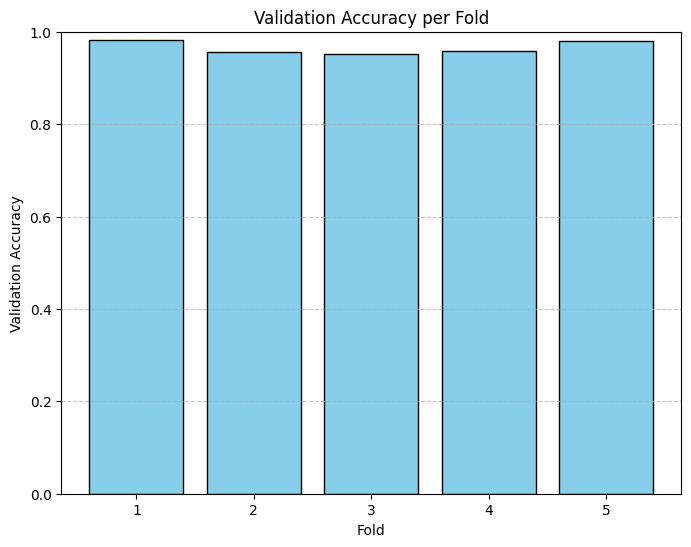

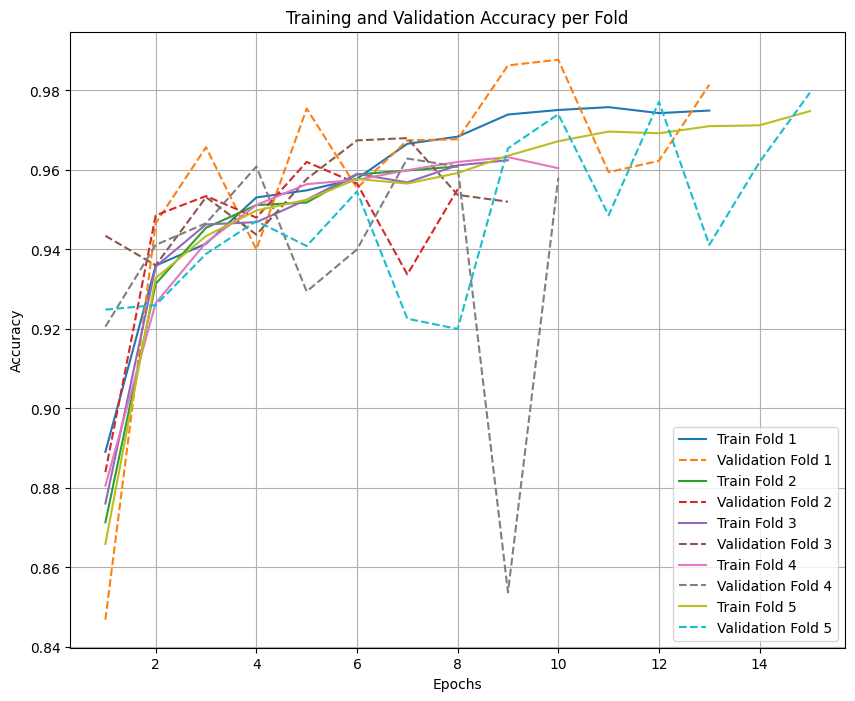

In [18]:
# Evaluate and visualize performance across the k-folds
fold_indices = list(range(1, N_SPLITS+1))  # e.g., [1, 2, 3, 4, 5]

plt.figure(figsize=(8,6))
plt.bar(fold_indices, val_scores, color='skyblue', edgecolor='black')
plt.title("Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Validation Accuracy")
plt.xticks(fold_indices)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Additionally, visualize training and validation accuracy curves for each fold
plt.figure(figsize=(10,8))
for i, hist in enumerate(histories):
    epochs = range(1, len(hist.history['accuracy']) + 1)
    plt.plot(epochs, hist.history['accuracy'], label=f'Train Fold {i+1}')
    plt.plot(epochs, hist.history['val_accuracy'], label=f'Validation Fold {i+1}', linestyle='--')
plt.title("Training and Validation Accuracy per Fold")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()